In [1]:
import math
import numpy as np
import codecs, json 
import cv2
import matplotlib.pyplot as plt
from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
c_error = np.array([[ 0.53,  0.17,  0.27,  0.27,  0.33,  0.33,  0.31,  0.28],
       [ 0.19, -0.05,  0.02,  0.05,  0.11,  0.06,  0.03, -0.01],
       [ 0.21, -0.  ,  0.13,  0.08,  0.14,  0.14,  0.04, -0.05],
       [ 0.27, -0.05,  0.09,  0.04,  0.15,  0.19,  0.05, -0.05],
       [ 0.22, -0.24, -0.14, -0.  ,  0.08,  0.16,  0.03, -0.05],
       [ 0.01, -0.4 , -0.28, -0.1 , -0.05,  0.07,  0.03, -0.05],
       [-0.23, -0.42, -0.3 , -0.22, -0.13,  0.01,  0.03, -0.08],
       [-0.21, -0.46, -0.28, -0.24, -0.17,  0.01, -0.08, -0.13]])

c_maxnoise = np.array([[0.42, 0.18, 0.24, 0.26, 0.36, 0.42, 0.45, 0.44],
       [0.22, 0.21, 0.26, 0.31, 0.2 , 0.28, 0.22, 0.36],
       [0.18, 0.14, 0.12, 0.37, 0.12, 0.14, 0.29, 0.32],
       [0.2 , 0.3 , 0.29, 0.13, 0.23, 0.15, 0.3 , 0.23],
       [0.31, 0.1 , 0.14, 0.28, 0.29, 0.31, 0.18, 0.38],
       [0.42, 0.23, 0.37, 0.31, 0.18, 0.34, 0.24, 0.3 ],
       [0.29, 0.26, 0.34, 0.3 , 0.15, 0.3 , 0.35, 0.28],
       [0.39, 0.46, 0.32, 0.42, 0.43, 0.37, 0.46, 0.4 ]])

def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
#     arr = arr - c_error
    arr = np.amax(arr, axis = 0) - c_maxnoise
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [3]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)


def show_gtemp(garr,ln,weight = None, mintemp = 26, maxtemp = 32):
    fig, axs = plt.subplots(ln, ln, figsize=(15, 15))
    amax = np.zeros((ln,ln))
    for n in range(ln**2):
        col = int(n/ln)
        row = int(n%ln)
        bicubic = griddata(points, garr[n].reshape(-1), (grid_x, grid_y), method='cubic')
        if np.any(weight) != None:
            wbicubic = griddata(points, weight[n].reshape(-1)*80, (grid_x, grid_y), method='cubic')/80
            wbicubic[wbicubic < 0] = 0
            wbicubic[wbicubic > 1] = 1
            bicubic = bicubic*(1-wbicubic) + np.amin(garr)*wbicubic
        ax = axs[col,row]
        pcm = ax.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
        ax.set_axis_off()
        amax[col,row] = np.amax(bicubic)
    
    fig.colorbar(pcm, ax= axs[:], fraction=0.0175,pad=0.02)

    plt.show()
    print(amax.round(2))

In [4]:
def get_weight(garr,arrbg):
    diff = garr.reshape(-1,64)-arrbg.reshape(-1)
    
    weight = np.ones(diff.shape)
    for i in range(diff.shape[0]):
        n = 0
        n_skew = 10000
        bicubic = np.around(griddata(points, diff[i], (grid_x, grid_y), method='cubic').reshape(-1) * 4)/4.
        sort_diff = np.unique(bicubic)
        mode =  0
        start = 0
        for j in range(int(sort_diff.shape[0]/2)):
            num = bicubic[bicubic == sort_diff[j]].shape[0]
            if (num > mode):
                mode = num
                start = j
        for j in range(max(2,start),int(sort_diff.shape[0]/2)):
            t_skew = abs(st.skew(bicubic[bicubic < sort_diff[j]] ))
            if t_skew < n_skew:
                n_skew = t_skew
                n = sort_diff[j]
        weight[i,diff[i] >= n] = 0 
    
    return weight.reshape(-1,8,8)

In [5]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol.reshape(-1,8,8)

# def output_interpolate(temp_path, ln2):
#     bgpath = 'train/' + temp_path + '/output-empty/1.txt'
#     interpol = np.zeros((4,ln2**2,8,8))
#     ln = 6
#     bg_max = 0
#     for i in range(4):
#         datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

#         garr = read_gtempdata(100,datapath,ln**2)
#         arrbg = read_tempdata(100,bgpath)

#         weight = get_weight(garr,arrbg)

#         bg_mean = np.sum(garr*(weight),axis = (1,2))/np.sum(weight,axis = (1,2))
#         bg_max += np.mean(bg_mean)

#         garr2 = (garr.transpose(1,2,0) -bg_mean).transpose(2,0,1)
#         interpol[i] = thermal_interpolate(garr2,ln,ln,ln2,ln2)
#         ln -= 1
#     bg_max /= 4
#     return interpol+bg_max

def output_interpolate(temp_path, ln2):
    bgpath = 'train/' + temp_path + '/output-empty/1.txt'
    interpol = np.zeros((4,ln2**2,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)
        arrbg = read_tempdata(100,bgpath)

        weight = get_weight(garr,arrbg)

        bg_mean = np.sum(garr*(weight),axis = (1,2))/np.sum(weight,axis = (1,2))
#         bg_max += np.mean(bg_mean)
        bg_max = max(bg_max,np.max(bg_mean))

        garr2 = (garr.transpose(1,2,0) -bg_mean).transpose(2,0,1)
        interpol[i] = thermal_interpolate(garr2,ln,ln,ln2,ln2)
        ln -= 1
#     bg_max /= 4
    return interpol+bg_max

def full_interpolate():
    ln = 6
    interpol = np.zeros((4,4,ln**2,8,8))
#     super_interpol = np.zeros((4,ln**3,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        interpol[i] = output_interpolate(temp_path[i],ln)
#         super_interpol[i] = thermal_interpolate(interpol[i],4,ln**2,ln,ln**2)
#     full_interpol = thermal_interpolate(super_interpol,3,ln**3,ln,ln**3).reshape(ln,ln,ln**2,8,8)
    
    amax = np.zeros((4,4,ln,ln))
    for amb in range(4):
        for layer in range(4):
            for n in range(ln**2):
                col = int(n/ln)
                row = int(n%ln)
                bicubic = griddata(points, interpol[amb,layer,n].reshape(-1), (grid_x, grid_y), method='cubic')
                amax[amb,layer,col,row] = np.amax(bicubic)
                
    return interpol, amax

In [6]:
interpol, amax = full_interpolate()
mean = np.mean(amax)

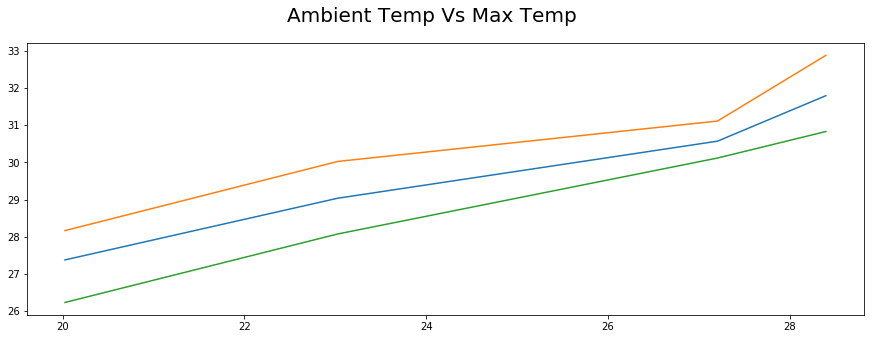

In [7]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = 0)
plt.plot(amb_temp,np.mean(center, axis = (1,2,3))+mean) 
plt.plot(amb_temp,np.amax(center, axis = (1,2,3))+mean)
plt.plot(amb_temp,np.amin(center, axis = (1,2,3))+mean)
plt.suptitle('Ambient Temp Vs Max Temp', fontsize = 20)
plt.show()

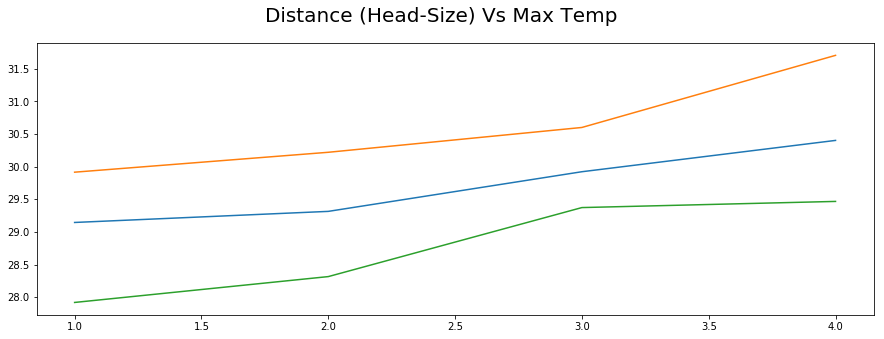

In [8]:
dis_head = np.linspace(1,4,4)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax.transpose(1,0,2,3)-np.mean(amax, axis = 1)
plt.plot(dis_head,np.mean(center, axis = (1,2,3)) + mean)
plt.plot(dis_head,np.amax(center, axis = (1,2,3)) + mean)
plt.plot(dis_head,np.amin(center, axis = (1,2,3)) + mean)
plt.suptitle('Distance (Head-Size) Vs Max Temp', fontsize = 20)
plt.show()

In [9]:
np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))

array([28.39548698, 27.20325227, 23.02636959, 20.02692516])

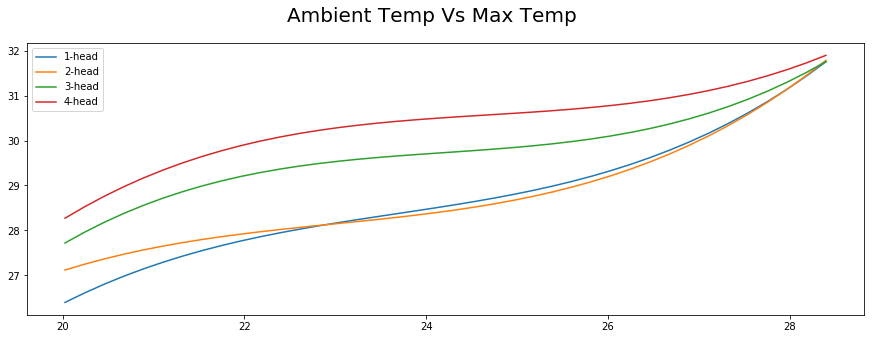

In [10]:
amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
x_new = np.linspace(amb_temp[0],amb_temp[3],40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(center, axis = (2,3)) + mean
cubic = interp1d(amb_temp, d_center[:,0], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '1-head')
cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '2-head')
cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '3-head')
cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
plt.plot(x_new,cubic(x_new), label = '4-head')
plt.legend()
# plt.plot(amb_temp,d_center[:,0]) 
# plt.plot(amb_temp,d_center[:,1])
# plt.plot(amb_temp,d_center[:,2])
# plt.plot(amb_temp,d_center[:,3])
plt.suptitle('Ambient Temp Vs Max Temp', fontsize = 20)
plt.show()

No handles with labels found to put in legend.


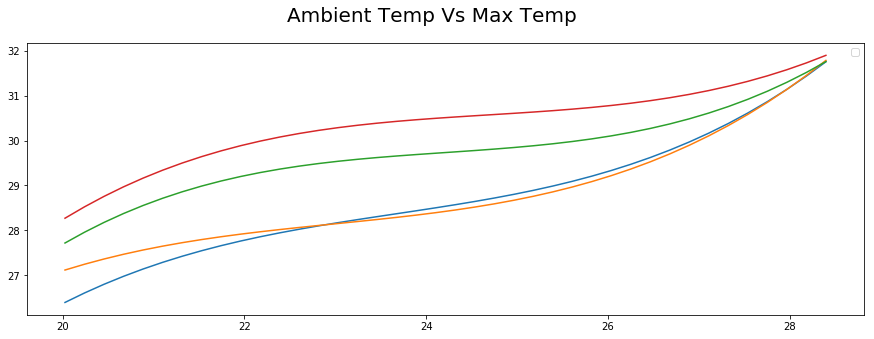

In [11]:


amb_temp = np.mean(np.amin(interpol, axis = (3,4)), axis = (1,2))
x_new = np.linspace(amb_temp[0],amb_temp[3],40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
center = amax-np.mean(amax, axis = (0,1))
d_center = np.mean(center, axis = (2,3)) + mean
cubic = interp1d(amb_temp, d_center[:,0], kind='cubic')
poly = np.polyfit(amb_temp,cubic(amb_temp),3)
plt.plot(x_new,poly[0]*(x_new**3) + poly[1]*x_new**2 + poly[2]*x_new + poly[3])
cubic = interp1d(amb_temp, d_center[:,1], kind='cubic')
poly = np.polyfit(amb_temp,cubic(amb_temp),3)
plt.plot(x_new,poly[0]*(x_new**3) + poly[1]*x_new**2 + poly[2]*x_new + poly[3])
cubic = interp1d(amb_temp, d_center[:,2], kind='cubic')
poly = np.polyfit(amb_temp,cubic(amb_temp),3)
plt.plot(x_new,poly[0]*(x_new**3) + poly[1]*x_new**2 + poly[2]*x_new + poly[3])
cubic = interp1d(amb_temp, d_center[:,3], kind='cubic')
poly = np.polyfit(amb_temp,cubic(amb_temp),3)
plt.plot(x_new,poly[0]*(x_new**3) + poly[1]*x_new**2 + poly[2]*x_new + poly[3])
plt.legend()
# plt.plot(amb_temp,d_center[:,0]) 
# plt.plot(amb_temp,d_center[:,1])
# plt.plot(amb_temp,d_center[:,2])
# plt.plot(amb_temp,d_center[:,3])
plt.suptitle('Ambient Temp Vs Max Temp', fontsize = 20)
plt.show()

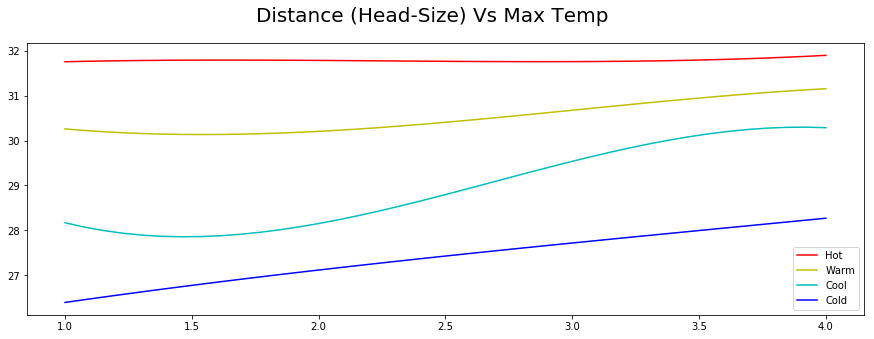

In [12]:
dis_head = np.linspace(1,4,4)
x_new = np.linspace(1,4,40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
cubic = interp1d(dis_head, d_center[0], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Hot', color= 'r')
cubic = interp1d(dis_head, d_center[1], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Warm', color= 'y')
cubic = interp1d(dis_head, d_center[2], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Cool', color= 'c')
cubic = interp1d(dis_head, d_center[3], kind='cubic')
plt.plot(x_new,cubic(x_new), label = 'Cold', color= 'b')
plt.legend()
plt.suptitle('Distance (Head-Size) Vs Max Temp', fontsize = 20)
plt.show()

In [13]:
center = amax-np.mean(amax, axis = (0,1))
amb_dis = np.mean(center, axis = (2,3))
amb_dis.round(2)

array([[ 2.06,  2.09,  2.06,  2.2 ],
       [ 0.56,  0.51,  0.98,  1.46],
       [-1.52, -1.54, -0.16,  0.59],
       [-3.3 , -2.58, -1.98, -1.42]])

In [14]:
center = amax-np.mean(amax, axis = (0,1))
amb_dis = np.mean(center, axis = (2,3))
amb_dis.round(2)

array([[ 2.06,  2.09,  2.06,  2.2 ],
       [ 0.56,  0.51,  0.98,  1.46],
       [-1.52, -1.54, -0.16,  0.59],
       [-3.3 , -2.58, -1.98, -1.42]])

In [15]:
center = amax.transpose(2,3,0,1)-np.mean(amax, axis = (2,3))
pos = np.mean(center, axis = (2,3))
pos.round(2)

array([[ 0.36,  0.16,  0.12,  0.22,  0.2 ,  0.33],
       [ 0.04, -0.12, -0.06, -0.01,  0.01,  0.1 ],
       [ 0.1 , -0.06, -0.09,  0.03, -0.04,  0.06],
       [-0.01, -0.22, -0.08,  0.04, -0.  ,  0.1 ],
       [-0.22, -0.32, -0.22, -0.09, -0.07,  0.04],
       [-0.12, -0.21, -0.11,  0.02, -0.02,  0.15]])

In [16]:
diff = 36.5-mean
diff

6.804515467387837

In [17]:
amb_temp

array([28.39548698, 27.20325227, 23.02636959, 20.02692516])

In [78]:
dis_head = np.linspace(1,4,4)
poly_dis = np.zeros((4,4))
amb_temp = np.array([28.39548698, 27.20325227, 23.02636959, 20.02692516])
# amb_dis = np.array([[ 2.2 ,  2.47,  2.44,  2.01],
#        [ 0.62,  0.74,  1.  ,  1.84],
#        [-1.85, -1.38, -0.35,  0.97],
#        [-2.91, -3.16, -2.83, -1.81]])
amb_dis = np.array([[ 2.06,  2.09,  2.06,  2.2 ],
       [ 0.56,  0.51,  0.98,  1.46],
       [-1.52, -1.54, -0.16,  0.59],
       [-3.3 , -2.58, -1.98, -1.42]])

for i in range(4):
    poly_dis[i] = np.polyfit(dis_head,amb_dis[i],3)
    print(poly_dis[i].round(2))
    
def get_bodytemp(temp,ambient,distance):
    amb_pts = np.zeros(4)
    for i in range(4):
        amb_pts[i] = poly_dis[i,0]*(distance**3) + poly_dis[i,1]*(distance**2) + poly_dis[i,2]*(distance) + poly_dis[i,3]
        
    poly = np.polyfit(amb_temp,amb_pts,3)
    ans = poly[0]*(ambient**3) + poly[1]*ambient**2 + poly[2]*ambient + poly[3]
    return (temp - ans + 6.804515467387837).round(2)
    
# vert = np.linspace(1,4,4)
# poly_vert = np.zeros((4,4))
# x_vert = np.linspace(1,4,40)
# for i in range(4):
#     cubic = interp1d(dis_head, amb_dis[i], kind='cubic')
#     poly_dis[i] = np.polyfit(x_dis,cubic(x_dis),3)

[ 0.04 -0.26  0.54  1.74]
[-0.08  0.77 -1.77  1.64]
[-0.34  2.73 -5.84  1.93]
[ 0.01 -0.14  1.05 -4.22]


In [ ]:
[ 0.04 -0.26  0.54  1.74]
[-0.08  0.77 -1.77  1.64]
[-0.34  2.73 -5.84  1.93]
[ 0.01 -0.14  1.05 -4.22]


In [19]:
get_bodytemp(31.53,27.26,4)

36.85

In [20]:
get_bodytemp(28.49,24.27,1.27)

36.71

In [21]:
get_bodytemp(28.34,21.31,2.62)

36.43

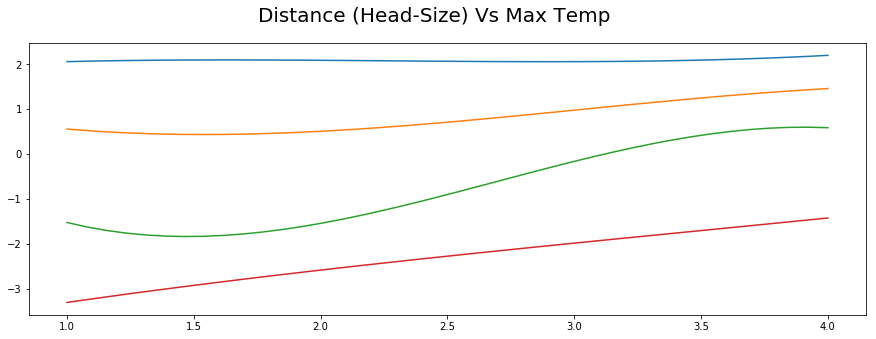

2.147360000000001
1.387679999999997
0.5878399999999715
-1.5326400000000007


In [22]:
dis_head = np.linspace(1,4,4)
x_new = np.linspace(1,4,40)
plt.figure(figsize=(15, 5))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
for i in range(4):
    plt.plot(x_new,poly_dis[i,0]*(x_new**3) + poly_dis[i,1]*x_new**2 + poly_dis[i,2]*x_new + poly_dis[i,3])
plt.suptitle('Distance (Head-Size) Vs Max Temp', fontsize = 20)
plt.show()

for i in range(4):
   print(poly_dis[i,0]*(3.8**3) + poly_dis[i,1]*3.8**2 + poly_dis[i,2]*3.8 + poly_dis[i,3])

In [23]:
np.median(interpol[1,2,3].round(2))

28.634999999999998

In [24]:
np.amin(interpol[0,3,35].round(2))

27.83

In [25]:
amax[0,3,5,5]

32.10548476249596

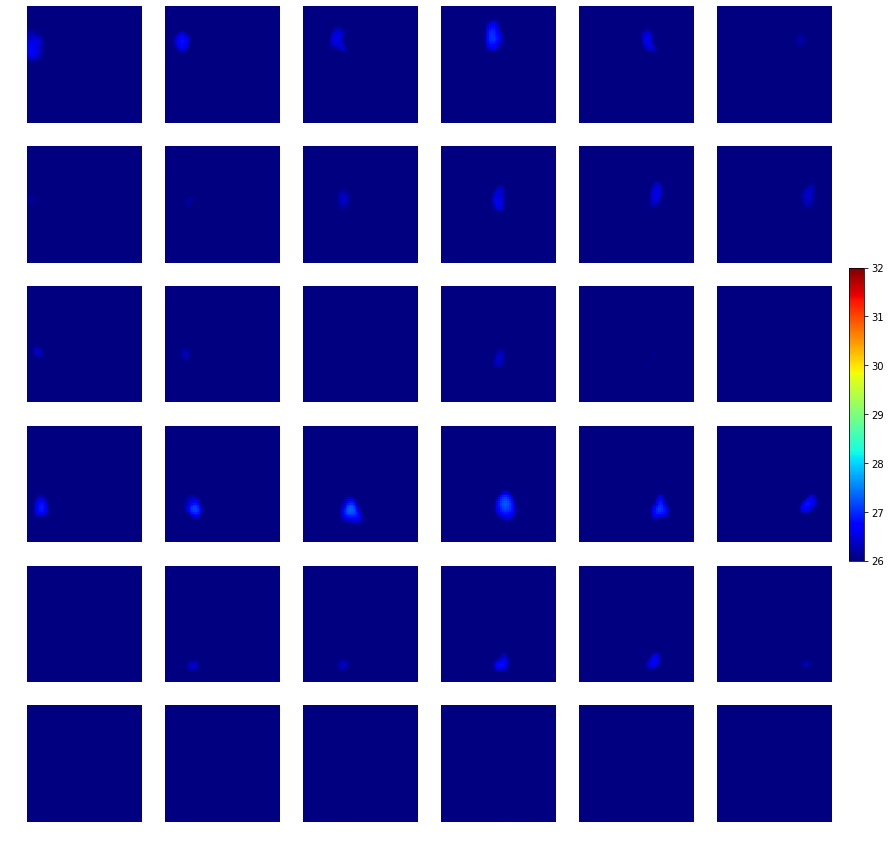

[[26.7  26.86 26.59 27.03 26.58 26.25]
 [26.18 26.16 26.38 26.62 26.56 26.4 ]
 [26.36 26.29 25.77 26.42 26.07 25.81]
 [26.91 27.14 27.33 27.27 27.08 26.84]
 [25.74 26.42 26.4  26.82 26.67 26.27]
 [25.36 25.61 26.04 26.09 25.55 25.72]]


In [77]:
show_gtemp(interpol[3,0],6)

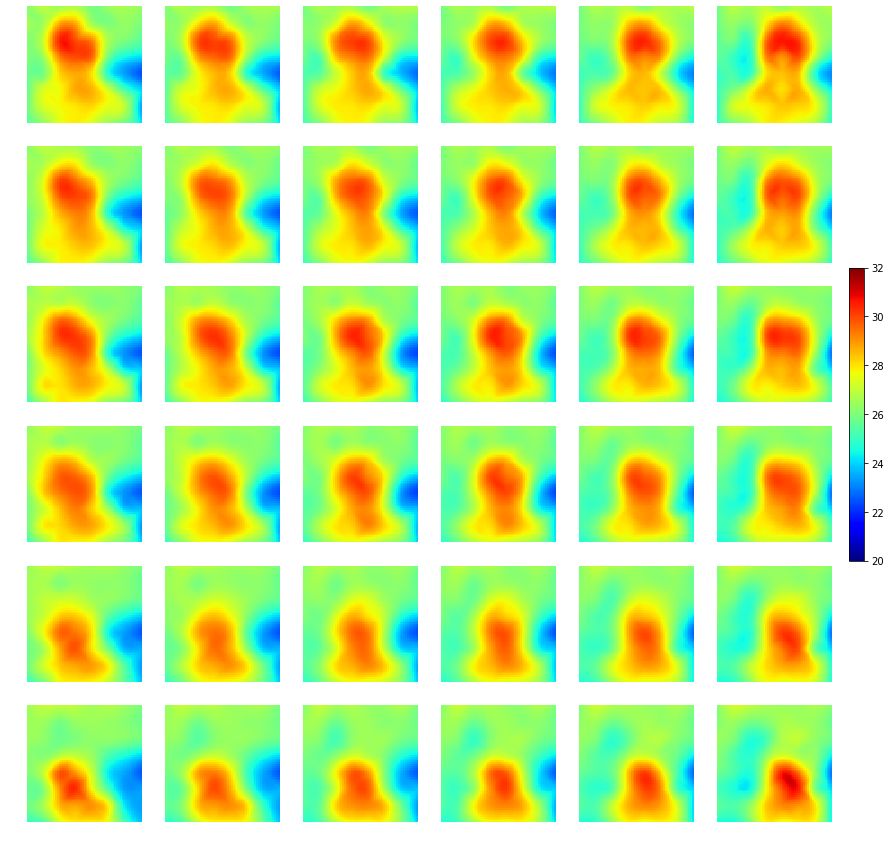

[[30.75 30.28 30.32 30.46 30.53 30.68]
 [30.41 30.08 30.2  30.31 30.29 30.28]
 [30.39 30.33 30.51 30.59 30.49 30.49]
 [29.93 30.01 30.25 30.3  30.18 30.14]
 [29.88 29.62 29.82 29.94 30.02 30.41]
 [30.42 29.98 30.03 30.28 30.42 31.22]]


In [27]:
show_gtemp(interpol[2,3],6,None,20,32)

In [28]:
b = amax.tolist() # nested lists with same data, indices
file_path = "amax.json" ## your path variable
json.dump(b, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

In [73]:
for i in range(4):
    for j in range(4):
        print([i,j,get_bodytemp(amax[i,j,0,0],np.amin(interpol[i,j,0]),j+1)])

[0, 0, 36.01]
[0, 1, 35.98]
[0, 2, 35.81]
[0, 3, 36.33]
[1, 0, 36.49]
[1, 1, 36.7]
[1, 2, 36.49]
[1, 3, 36.64]
[2, 0, 37.46]
[2, 1, 37.06]
[2, 2, 37.24]
[2, 3, 37.15]
[3, 0, 36.53]
[3, 1, 37.33]
[3, 2, 37.78]
[3, 3, 38.16]


In [79]:
for i in range(4):
    for j in range(4):
        print([i,j,get_bodytemp(np.mean(amax[i,j]),np.mean(np.amin(interpol[i,j], axis = (0,1))),j+1)])

[0, 0, 35.98]
[0, 1, 35.6]
[0, 2, 35.65]
[0, 3, 35.7]
[1, 0, 36.43]
[1, 1, 36.34]
[1, 2, 36.37]
[1, 3, 36.32]
[2, 0, 36.3]
[2, 1, 36.32]
[2, 2, 36.37]
[2, 3, 36.26]
[3, 0, 36.05]
[3, 1, 36.18]
[3, 2, 35.69]
[3, 3, 35.31]


In [75]:
for i in range(4):
    for j in range(4):
        print([i,j,get_bodytemp(np.mean(amax[i,j]),np.mean(np.amin(interpol[i,j], axis = (0,1))),j+1)])

[0, 0, 35.98]
[0, 1, 35.6]
[0, 2, 35.65]
[0, 3, 35.7]
[1, 0, 36.43]
[1, 1, 36.34]
[1, 2, 36.37]
[1, 3, 36.32]
[2, 0, 36.3]
[2, 1, 36.32]
[2, 2, 36.37]
[2, 3, 36.26]
[3, 0, 36.05]
[3, 1, 36.18]
[3, 2, 35.69]
[3, 3, 35.31]


In [72]:
for t in range(4):
    for d in range(4):
        m = np.ones(36)
        for i in range(36):
            a = amax.reshape(4,4,-1)[t,d,i]
            b = np.amin(interpol[t,d,i])
            m[i] = get_bodytemp(a,b,d+1)
            print([a.round(2),b.round(2),m[i]])
        print([t,d,np.mean(m)])
        print("")

[31.46, 28.52, 36.01]
[31.77, 28.39, 36.53]
[31.22, 28.15, 36.33]
[31.78, 28.32, 36.64]
[31.78, 28.41, 36.51]
[32.01, 28.55, 36.51]
[31.43, 28.93, 35.27]
[31.31, 28.3, 36.2]
[31.89, 28.45, 36.55]
[31.82, 28.3, 36.71]
[31.76, 28.24, 36.73]
[31.67, 28.22, 36.67]
[31.92, 28.93, 35.76]
[31.79, 28.59, 36.22]
[31.8, 28.35, 36.61]
[31.65, 28.4, 36.39]
[31.48, 28.22, 36.49]
[31.75, 28.31, 36.63]
[31.62, 29.12, 35.11]
[31.73, 28.75, 35.89]
[31.63, 28.39, 36.38]
[31.88, 28.38, 36.66]
[31.79, 28.07, 37.01]
[31.99, 28.29, 36.89]
[31.61, 28.84, 35.61]
[31.75, 28.3, 36.64]
[31.69, 28.2, 36.73]
[31.84, 28.14, 36.96]
[31.58, 28.11, 36.74]
[32.22, 28.52, 36.77]
[31.75, 28.53, 36.28]
[32.05, 28.51, 36.61]
[32.09, 28.4, 36.83]
[31.75, 28.27, 36.68]
[32.07, 28.11, 37.23]
[31.74, 28.26, 36.69]
[0, 0, 36.4575]

[31.63, 28.61, 35.98]
[31.6, 28.46, 36.22]
[31.54, 28.41, 36.24]
[31.61, 28.32, 36.44]
[31.9, 28.21, 36.9]
[32.21, 28.26, 37.14]
[31.57, 28.88, 35.44]
[31.67, 28.63, 35.98]
[31.6, 28.37, 36.36]
[31.6

[28.98, 19.63, 37.74]
[28.56, 19.68, 37.23]
[28.54, 19.73, 37.15]
[28.78, 20.35, 36.63]
[28.6, 21.52, 35.47]
[28.83, 21.27, 35.86]
[3, 3, 36.64444444444445]



In [33]:
amax[0,0,0,0]

31.456585365853662

In [68]:
get_bodytemp(30.34, 27.29,0)

35.52

In [ ]:
get_bodytemp(30.34, 27.29,0)

In [39]:
interpol[0,0,0].reshape(8,8).round(2)

array([[29.74, 30.98, 31.17, 31.4 , 31.3 , 31.24, 31.46, 31.22],
       [29.94, 30.95, 30.4 , 30.6 , 30.71, 30.88, 30.69, 30.8 ],
       [29.98, 31.27, 30.29, 30.54, 30.79, 30.52, 30.62, 31.09],
       [30.71, 31.36, 30.37, 30.28, 29.68, 29.51, 29.36, 29.43],
       [30.35, 31.31, 30.52, 29.88, 29.62, 29.35, 29.48, 29.28],
       [29.99, 30.68, 30.04, 29.6 , 29.73, 29.57, 29.42, 29.61],
       [29.37, 30.15, 30.07, 29.36, 30.01, 29.86, 29.81, 29.88],
       [28.52, 29.2 , 29.59, 29.24, 29.48, 29.29, 29.2 , 29.26]])

In [36]:
amax.shape

(4, 4, 6, 6)

In [37]:
interpol.shape

(4, 4, 36, 8, 8)